### Import dependencies

In [1]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
from random import randrange,sample,randint
import warnings
warnings.filterwarnings('ignore')

### Build toy data

In [2]:
a = np.random.normal(0,1,2000).reshape(2000,1)
b = np.ones((2000,2))

for i in range(2000):
    b[i][0] = a[i]
    b[i][1] = a[i]*2  + np.random.normal()
    
df = pandas.DataFrame(b, columns = ['X','Y'])
df

,X,Y
0,-0.790028,-3.172311
1,0.637613,0.024114
2,0.065250,-1.398227
3,0.465028,1.042471
4,-0.021471,1.169972
...,...,...
1995,-0.590557,-0.809890
1996,-0.243803,-0.283205
1997,-1.965734,-3.852365
1998,0.318094,0.028686


In [3]:
yield_column = df.loc[:, df.columns == 'Y'] 
del df['Y']
normalized_df = (df-df.mean())/df.std()
normalized_df = pandas.merge(normalized_df, yield_column, left_index=True, right_index=True)
normalized_df

,X,Y
0,-0.782109,-3.172311
1,0.679686,0.024114
2,0.093631,-1.398227
3,0.502972,1.042471
4,0.004835,1.169972
...,...,...
1995,-0.577865,-0.809890
1996,-0.222816,-0.283205
1997,-1.985940,-3.852365
1998,0.352523,0.028686


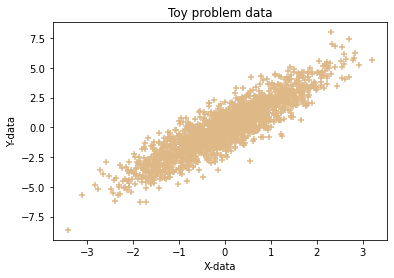

In [4]:
plt.scatter('X','Y',data =normalized_df, marker = '+', color = 'burlywood')
plt.ylabel('Y-data')
plt.xlabel('X-data')
plt.title('Toy problem data')
plt.show()

In [5]:
def mse(y_pred,y_test):
    '''Returns the mean squared error given two numpy arrays'''
    sum_squared_error = np.sum(np.square(y_test - y_pred))
    m_s_e = sum_squared_error/len(y_pred)
    
    return m_s_e

In [6]:
def find_split(x,y):
    'Returns the best split based on variance reduction'
    
    best = {'weighting_combination' : np.inf}
    
    for i in range(x.shape[1]):
        t_i = len(x[:,i]) #total indices
        for split in np.unique(x[:,i]):
            
            left_indices = np.where(x[:,i] <= split)[0]
            left_node_var = np.var(y[left_indices])
            
            t_l = len(left_indices)#total left indices
            
            
            right_indices = np.where(x[:,i] > split)[0]
            right_node_var = np.var(y[right_indices])
            
            t_r = len(right_indices)# total right indices


            weighting_combination = (t_l/ t_i) * left_node_var +(t_r/t_i) *right_node_var


            if weighting_combination < best['weighting_combination']:
                
                best = {'feature' : i,
                        'split' : split,
                        'weighting_combination' : weighting_combination, 
                        'left_indices' : left_indices,
                        'right_indices' : right_indices }


    return best

In [7]:
def build_tree(x, y, mean ,max_depth = np.inf,min_instances = 50):
    # Check if either of the stopping conditions have been reached. If so generate a leaf node...
    
    
    if max_depth==1 :
        # Generate a leaf node...

      
        value = np.mean(y)
        return {'leaf' : True, 'class' : value}
    
    else:
        
        move = find_split(x, y)
        if 'left_indices' not in move or 'right_indices' not in move:
            
            return {'leaf' : True, 'class' : mean }
        
        elif len(move['left_indices'])<=min_instances or len(move['right_indices']) <=min_instances :

            value = np.mean(y)
            return {'leaf' : True, 'class' : value}


        
        left = build_tree(x[move['left_indices'],:], y[move['left_indices']],mean, max_depth - 1,min_instances = 50)
        right = build_tree(x[move['right_indices'],:], y[move['right_indices']],mean, max_depth - 1,min_instances = 50)
        
        return {'leaf' : False,
                'feature' : move['feature'],
                'split' : move['split'],
                'weighting_combination' : move['weighting_combination'],
                'left' : left,
                'right' : right}

In [8]:
def predict(tree, samples):
    """Predicts class for every entry of a data matrix."""
    ret = np.empty(samples.shape[0], dtype=float)
    ret.fill(-1)
    indices = np.arange(samples.shape[0])
    
    def tranverse(node, indices):
        nonlocal samples
        nonlocal ret
        
        if node['leaf']:
            ret[indices] = node['class']
        
        else:
            
            going_left = samples[indices, node['feature']] <= node['split']
            
            left_indices = indices[going_left]
            right_indices = indices[np.logical_not(going_left)]
            
            if left_indices.shape[0] > 0:
                tranverse(node['left'], left_indices)
                
            if right_indices.shape[0] > 0:
                tranverse(node['right'], right_indices)
    
    tranverse(tree, indices)
    return ret

In [9]:
def bootstrapping(dataframe):
    data_range = len(dataframe)
    a= []
    for i in range(data_range):
        b= randrange(0,data_range)
        a.append(b)
    bootstrapped_df = dataframe.iloc[a,:]
    return bootstrapped_df
    

In [10]:
def random_subspace(dataframe):
    number_of_features = len(dataframe.columns) 
    if number_of_features == 1:
        number_random_features = 1
    else:
        number_random_features  = int(number_of_features**0.5)
    
    a= sample(range(0,number_of_features-1),number_random_features)# Generates a list of unique random numbers for 0 up to number of features -1
    a.append(-1)
    random_dataframe = dataframe.iloc[:,a]
    return random_dataframe

In [11]:
def build_forest(train_data,max_depth =20 ,min_instances = 5,no_of_trees=15):
    forest = []
    for i in range(no_of_trees):
        train_data_tree = bootstrapping(train_data)
        train_data_tree = random_subspace(train_data_tree)
        x_train = train_data_tree.iloc[:,:-1].to_numpy()
        y_train = train_data_tree.iloc[:,-1].to_numpy()
        y_train_mean = y_train.mean()
        tree = build_tree(x_train,y_train,y_train_mean,max_depth,min_instances)
        forest.append(tree)
    return forest

In [12]:
def predict_forest(forest, test_data):
    
    
    predictions =[]
    for tree in forest:
        y_pred_tree= predict(tree,test_data)
        predictions.append(y_pred_tree)

    total = 0
    for array in predictions:
        total += array
    y_pred_forest = total/(len(forest))
    
    return y_pred_forest
        

In [13]:
# Split the data into 60%-40% for train/test
split = int(len(df)*0.6)
data = np.array(normalized_df)
np.random.seed(0)
shuffle = np.random.permutation(len(data))


In [14]:
train_data_forest = normalized_df.iloc[:split,:]
test_data_forest = normalized_df.iloc[split:,:]
x_test_forest = test_data_forest.iloc[:,:-1].to_numpy()
y_test_forest = test_data_forest.iloc[:,-1].to_numpy()
train_data_forest

,X,Y
0,-0.782109,-3.172311
1,0.679686,0.024114
2,0.093631,-1.398227
3,0.502972,1.042471
4,0.004835,1.169972
...,...,...
1195,0.009307,0.325683
1196,-0.523132,0.065901
1197,0.798995,1.412241
1198,0.788522,0.781504


In [15]:
forest = build_forest(train_data_forest)
y_pred_forest = predict_forest(forest, x_test_forest)
print("The mean squared error for the Random Regression Forest toy problem is {}".format(mse(y_pred_forest,y_test_forest)))

The mean squared error for the Random Regression Forest toy problem is 1.0985649746061086


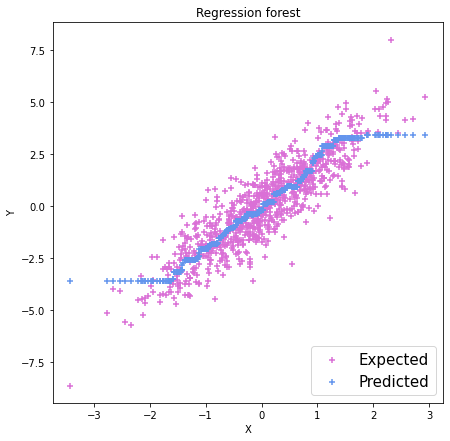

In [16]:
plt.figure(figsize=(7,7))
plt.scatter(x_test_forest,y_test_forest,color = 'orchid',marker = '+')
plt.scatter(x_test_forest,y_pred_forest,color = 'cornflowerblue',marker = '+')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Regression forest')
plt.legend(["Expected", "Predicted"], loc ="lower right",prop={'size': 15} )